In [1]:
import os

import glob
import numpy  as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import torch 

pd.set_option('display.width', 1000)


INPUT_CLEAN_DATA_PATH = '../../../data/clean'
INPUT_TENSOR_DATA_PATH = '../../../data/tensors'

## Exploratory data analysis of bug reports datasets

In [2]:
def read_data(project):
    def read_dataframe(filename):
        filepath = os.path.join(INPUT_CLEAN_DATA_PATH, filename) 
        data     = pd.read_csv(filepath)
        return data
    
    train_data = read_dataframe('{}_bug_report_train_data.csv'.format(project))
    train_data['type'] =  'train'
    test_data  = read_dataframe('{}_bug_report_test_data.csv'.format(project))
    test_data['type']  = 'test'
    
    return pd.concat([train_data, test_data])

def print_data_info(reports):
    (rows, columns) = reports.shape[0], reports.shape[1]
    labels = reports['label'].value_counts()
    types  = reports['type'].value_counts()
    print('The dataset has {} rows, {} columns'.format(rows, columns))
    print('The dataset has {} rows with label 0, {} rows with label 1'.format(labels[0], labels[1]))
    print('The dataset has {} rows with type train, {} rows with type test'.format(types[0], types[1]))


In [3]:
all_bug_reports_data =  None
for project in ['eclipse', 'freedesktop', 'gcc', 'gnome', 'mozilla', 'winehq']:
    print(project.upper())
    bug_reports_data=read_data(project)
    bug_reports_data['project'] =  project
    print_data_info(bug_reports_data)
    
    if all_bug_reports_data is None: 
       all_bug_reports_data =  bug_reports_data
    else:
       all_bug_reports_data = pd.concat([all_bug_reports_data, bug_reports_data])

ECLIPSE
The dataset has 9627 rows, 4 columns
The dataset has 4879 rows with label 0, 4748 rows with label 1
The dataset has 7220 rows with type train, 2407 rows with type test
FREEDESKTOP
The dataset has 7636 rows, 4 columns
The dataset has 3833 rows with label 0, 3803 rows with label 1
The dataset has 5727 rows with type train, 1909 rows with type test
GCC
The dataset has 9980 rows, 4 columns
The dataset has 5002 rows with label 0, 4978 rows with label 1
The dataset has 7485 rows with type train, 2495 rows with type test
GNOME
The dataset has 7763 rows, 4 columns
The dataset has 3902 rows with label 0, 3861 rows with label 1
The dataset has 5822 rows with type train, 1941 rows with type test
MOZILLA
The dataset has 9919 rows, 4 columns
The dataset has 4981 rows with label 0, 4938 rows with label 1
The dataset has 7439 rows with type train, 2480 rows with type test
WINEHQ
The dataset has 6063 rows, 4 columns
The dataset has 3036 rows with label 0, 3027 rows with label 1
The dataset has

In [4]:
display(all_bug_reports_data.iloc[5, [0,1]])

long_description    when an internal transition of a composite sta...
label                                                               1
Name: 5, dtype: object

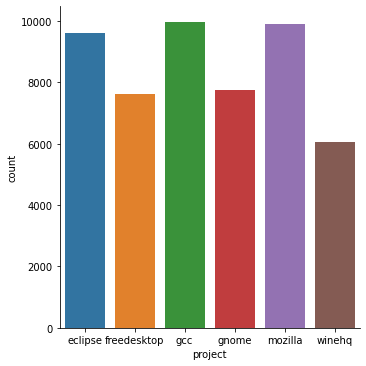

In [5]:
sns.catplot(data=all_bug_reports_data, kind='count', x='project')

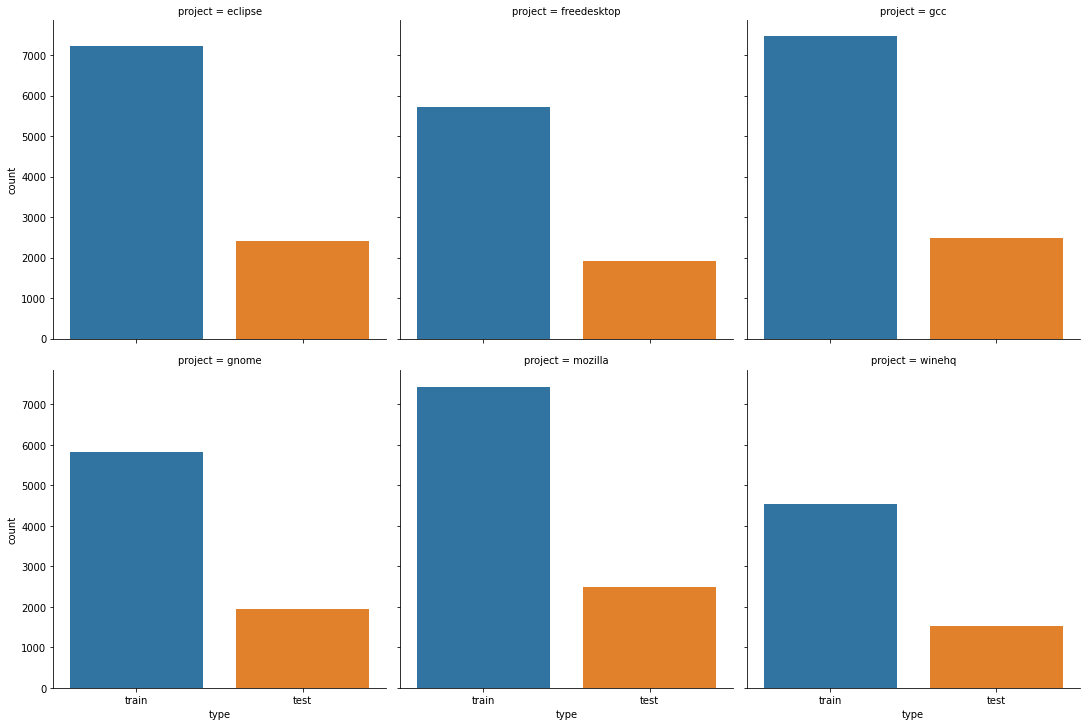

In [6]:
_=sns.catplot(data=all_bug_reports_data, kind="count", x='type', col='project', col_wrap=3)

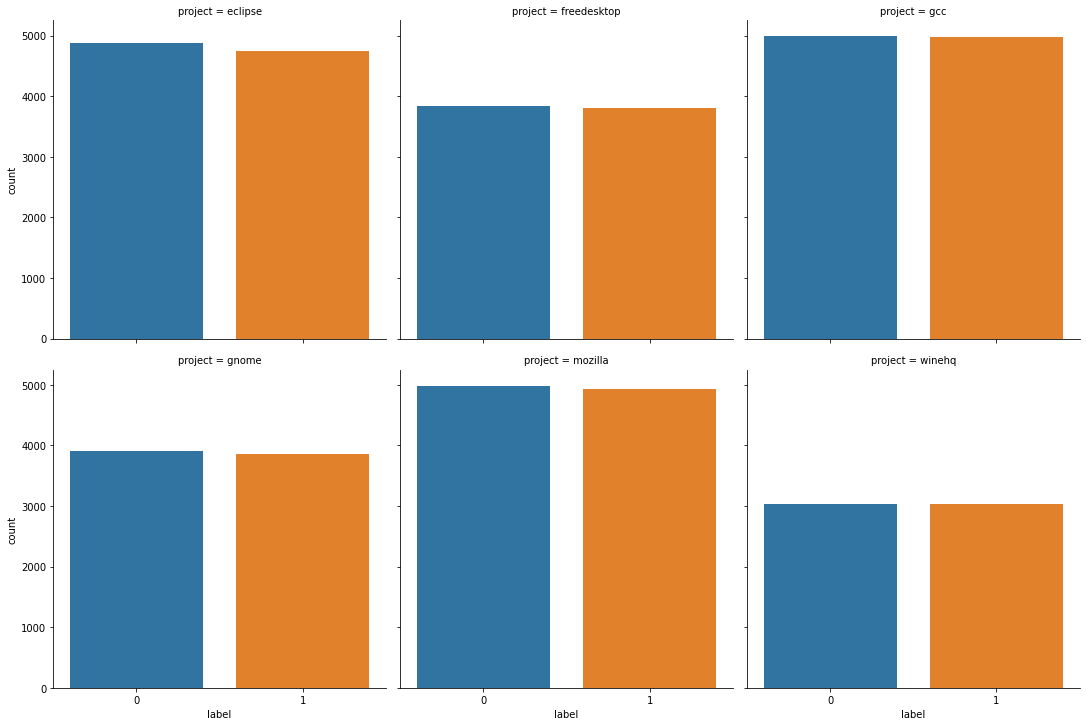

In [7]:
_=sns.catplot(data=all_bug_reports_data, kind="count", x='label', col='project', col_wrap=3)

## Explore data analysis of bug reports tensors

In [8]:
def read_reports_data(filename, batch_size=1000):
    filepath  = os.path.join(INPUT_CLEAN_DATA_PATH, filename)
    reader = pd.read_csv(filepath, header=None, skiprows=1, chunksize=batch_size, low_memory=False)
    return reader

def read_tensors(project, step='train'):
    
    tensors_path  = os.path.join(INPUT_TENSOR_DATA_PATH, "_{}_bug_report_{}_*.pt".format(project, step))
    tensors_files = sorted(glob.glob(tensors_path))
    tensors_data  = None 
    for file in tensors_files:
        if tensors_data is None:
            tensors_data = torch.load(file)
        else:
            tensors_data = np.vstack((tensors_data, torch.load(file)))

    X = tensors_data[:, :-1].copy()
    y = tensors_data[:, -1].copy().astype(int)

    return (X, y)


In [9]:
X_train, y_train = read_tensors('eclipse', 'train')

In [10]:
X_train.shape

(160, 768)

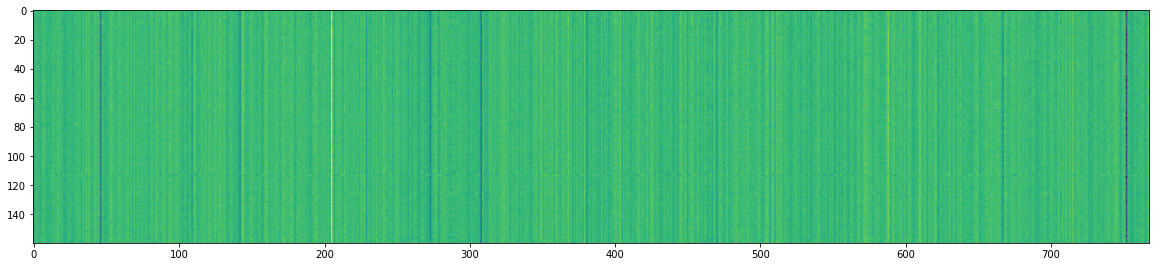

In [11]:
from matplotlib.pyplot import imshow
%matplotlib inline

#image is a numpy array
plt.figure(figsize=(20,10))
_=imshow(X_train)

In [12]:
y_train.astype(int)

array([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1])

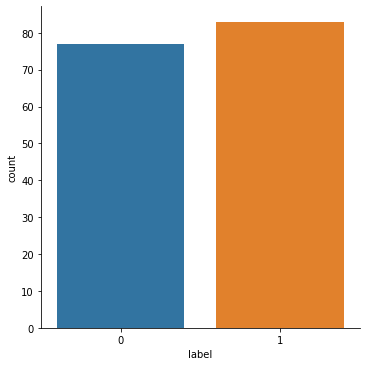

In [13]:
_=sns.catplot(data=pd.DataFrame(y_train.astype(int), columns=['label']), kind='count', x='label')

In [14]:
BATCH_SIZE=1000
test_file_reader = read_reports_data('{}_bug_report_test_data.csv'.format(project), BATCH_SIZE)

for test_batch in test_file_reader:
    #print('Extracting features from testing batch {}'.format(i))
    print('Chunck shape : {}'.format(test_batch.shape))

Chunck shape : (1000, 2)
Chunck shape : (516, 2)
